# Análisis de series temporales - Trabajo práctico

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_predict
from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy.special import inv_boxcox

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, GRU, Dense, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Análisis inicial de los datos

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/TrafficPrediction.csv", index_col=0, parse_dates=True)

In [ ]:
df.head(10)

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041
2015-11-01 05:00:00,1,6,20151101051
2015-11-01 06:00:00,1,9,20151101061
2015-11-01 07:00:00,1,8,20151101071
2015-11-01 08:00:00,1,11,20151101081


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
dfj2=df[df.Junction==2]

Se quita de la serie la tendencia cíclica semanal para dar prioridad en el modelo a los ciclos diarios, con el objetivo de simplificar el modelo de la red neuronal.

In [ ]:
periodo=168

data_graphic_real=np.array(dfj2['Vehicles'])
rows=int(len(dfj2['Vehicles'])/periodo)
data_array=np.array(dfj2['Vehicles'])

cant_data=rows*periodo
start=len(dfj2)-cant_data
data=data_array[start:].reshape(rows,periodo)
print ("Cantidad de períodos:",data.shape[0])
betas=data.mean(axis=0)
print ("Parámetros estimados (betas):\n",betas)

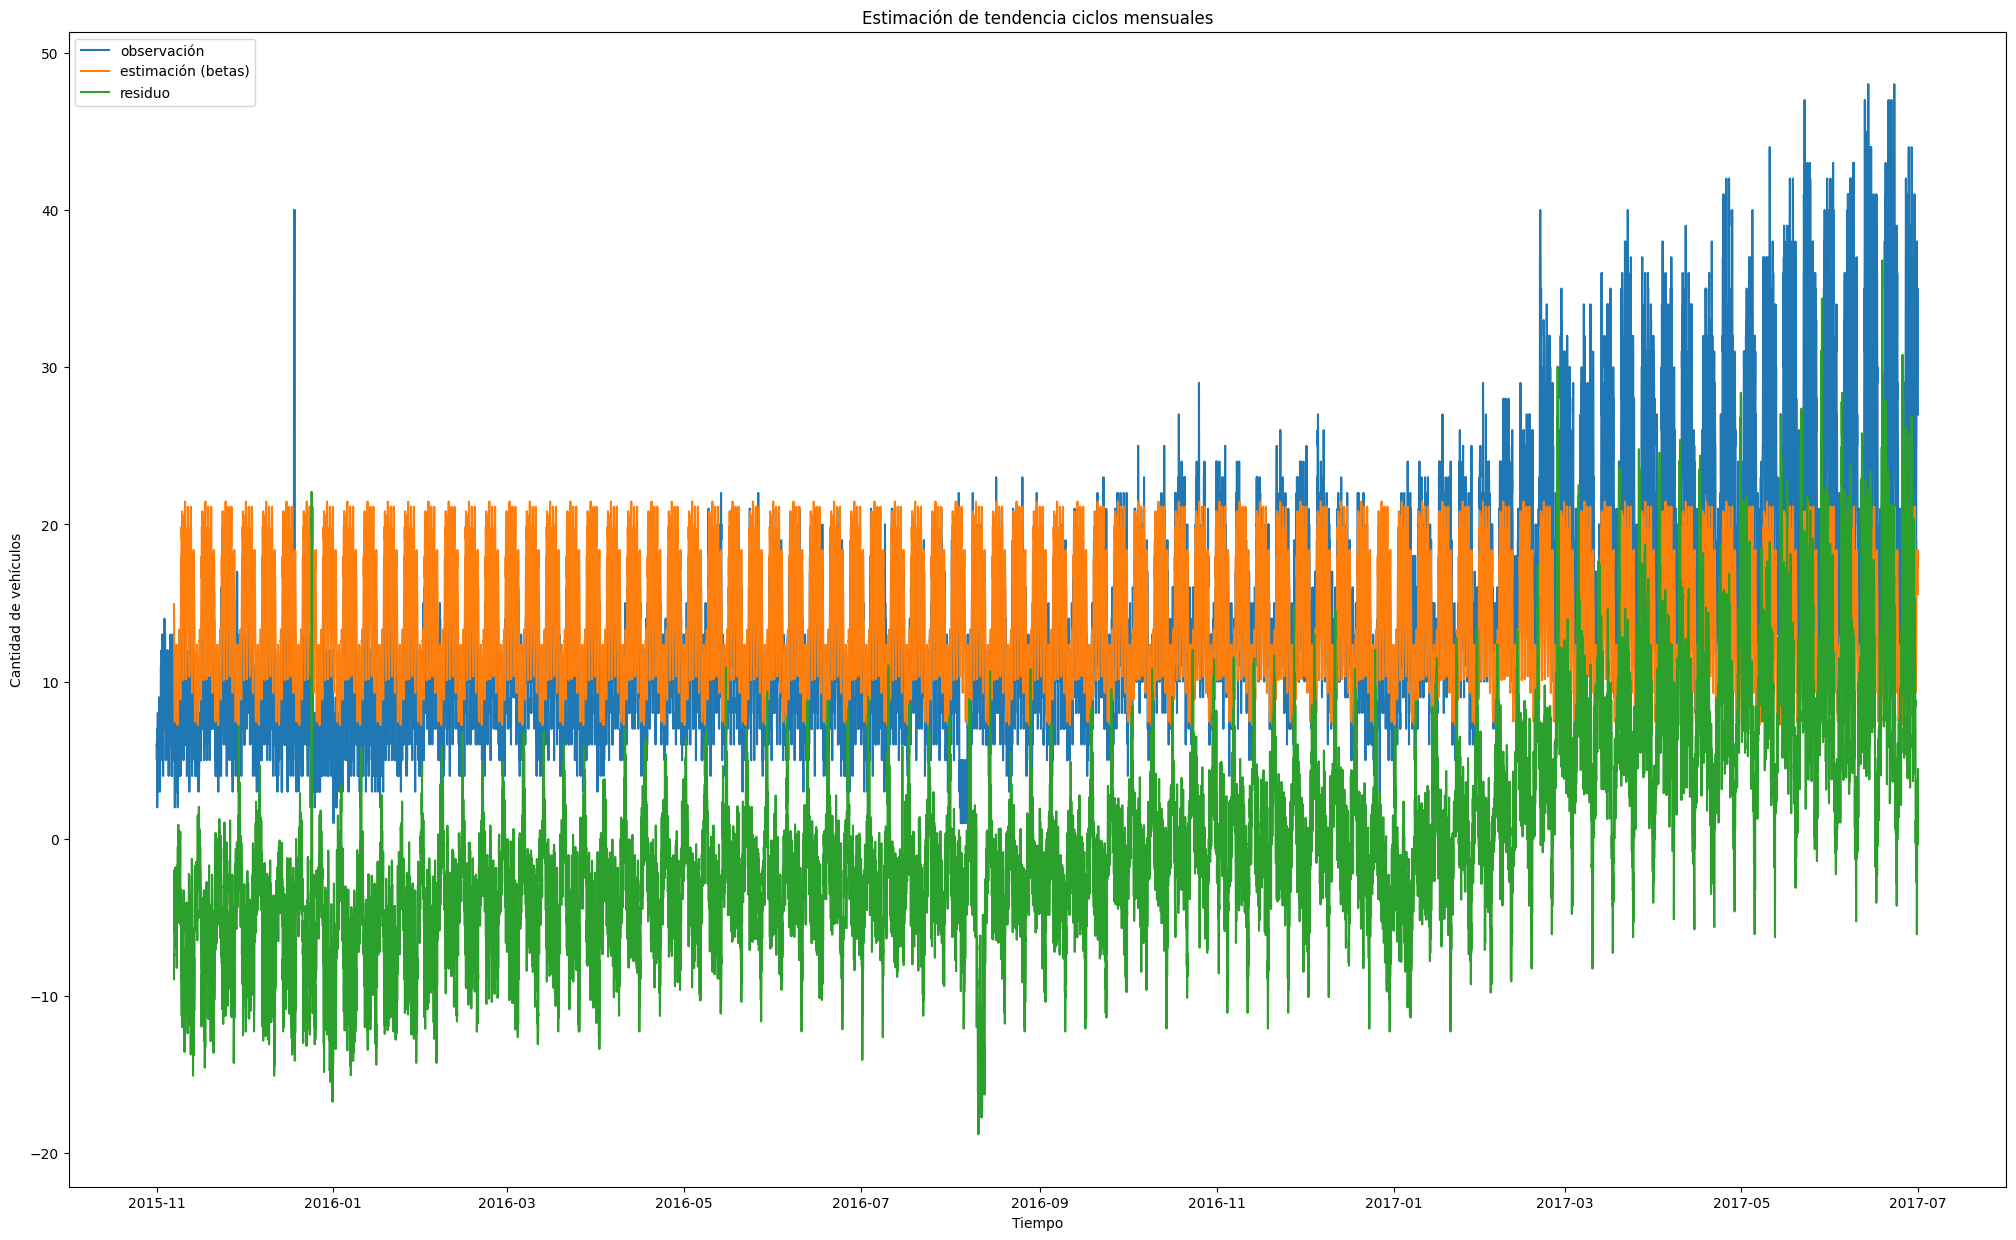

In [ ]:
parameters = {'figure.figsize': (25,15)}
plt.rcParams.update(parameters)

est = np.tile(betas,rows)

plt.plot(dfj2.index,data_graphic_real,label='observación')

plt.plot(dfj2[start:].index,est,label='estimación (betas)')

resid=data_graphic_real[0:rows*periodo]-est
plt.plot(dfj2[start:].index,resid,label='residuo')
plt.title("Estimación de tendencia ciclos mensuales")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos")
plt.show()

## Red Neuronal

### Normalizar los datos

In [ ]:
random.set_seed(5)

resid = resid.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
resid = scaler.fit_transform(resid)

resid = resid.flatten()

### Ventana deslizante

In [ ]:
def get_feature_target(data,look_back):
    end_len = len(data)
    X = []
    y = []
    steps = look_back
    for i in range(steps, end_len):
        X.append(data[i - steps:i])
        y.append(data[i])
    X, y = np.array(X), np.array(y)
    X = np.expand_dims(X, axis=2)
    return X ,y

In [ ]:
look_back=24
X, y = get_feature_target(resid,look_back)
print (len(resid))
print (X.shape)
print (y.shape)

14448
(14424, 24, 1)
(14424,)


### Train y test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=7, shuffle=False)

In [ ]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(13702, 24, 1)
(13702,)
(722, 24, 1)
(722,)


In [ ]:
input_shape = X_train[0].shape
print (input_shape)

(24, 1)


### Modelo

#### LSTM

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(units=50, input_shape=(input_shape), activation='tanh'))
model_2.add(Dense(units=1))

model_2.compile(optimizer=Adam(),loss='mean_squared_error')

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


##### Entrenamiento y validación

In [ ]:
hist_2 = model_2.fit(X_train,y_train, epochs=100, validation_split=0.2, batch_size=100)

Epoch 1/100
110/110 [==============================] - 6s 29ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 2/100
110/110 [==============================] - 3s 23ms/step - loss: 0.0026 - val_loss: 0.0052
Epoch 3/100
110/110 [==============================] - 4s 32ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 4/100
110/110 [==============================] - 3s 30ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 5/100
110/110 [==============================] - 3s 24ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 6/100
110/110 [==============================] - 3s 23ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 7/100
110/110 [==============================] - 3s 24ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 8/100
110/110 [==============================] - 3s 30ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 9/100
110/110 [==============================] - 4s 32ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 10/100
110/110 [==============================] - 3s 23ms/step - loss: 0.001

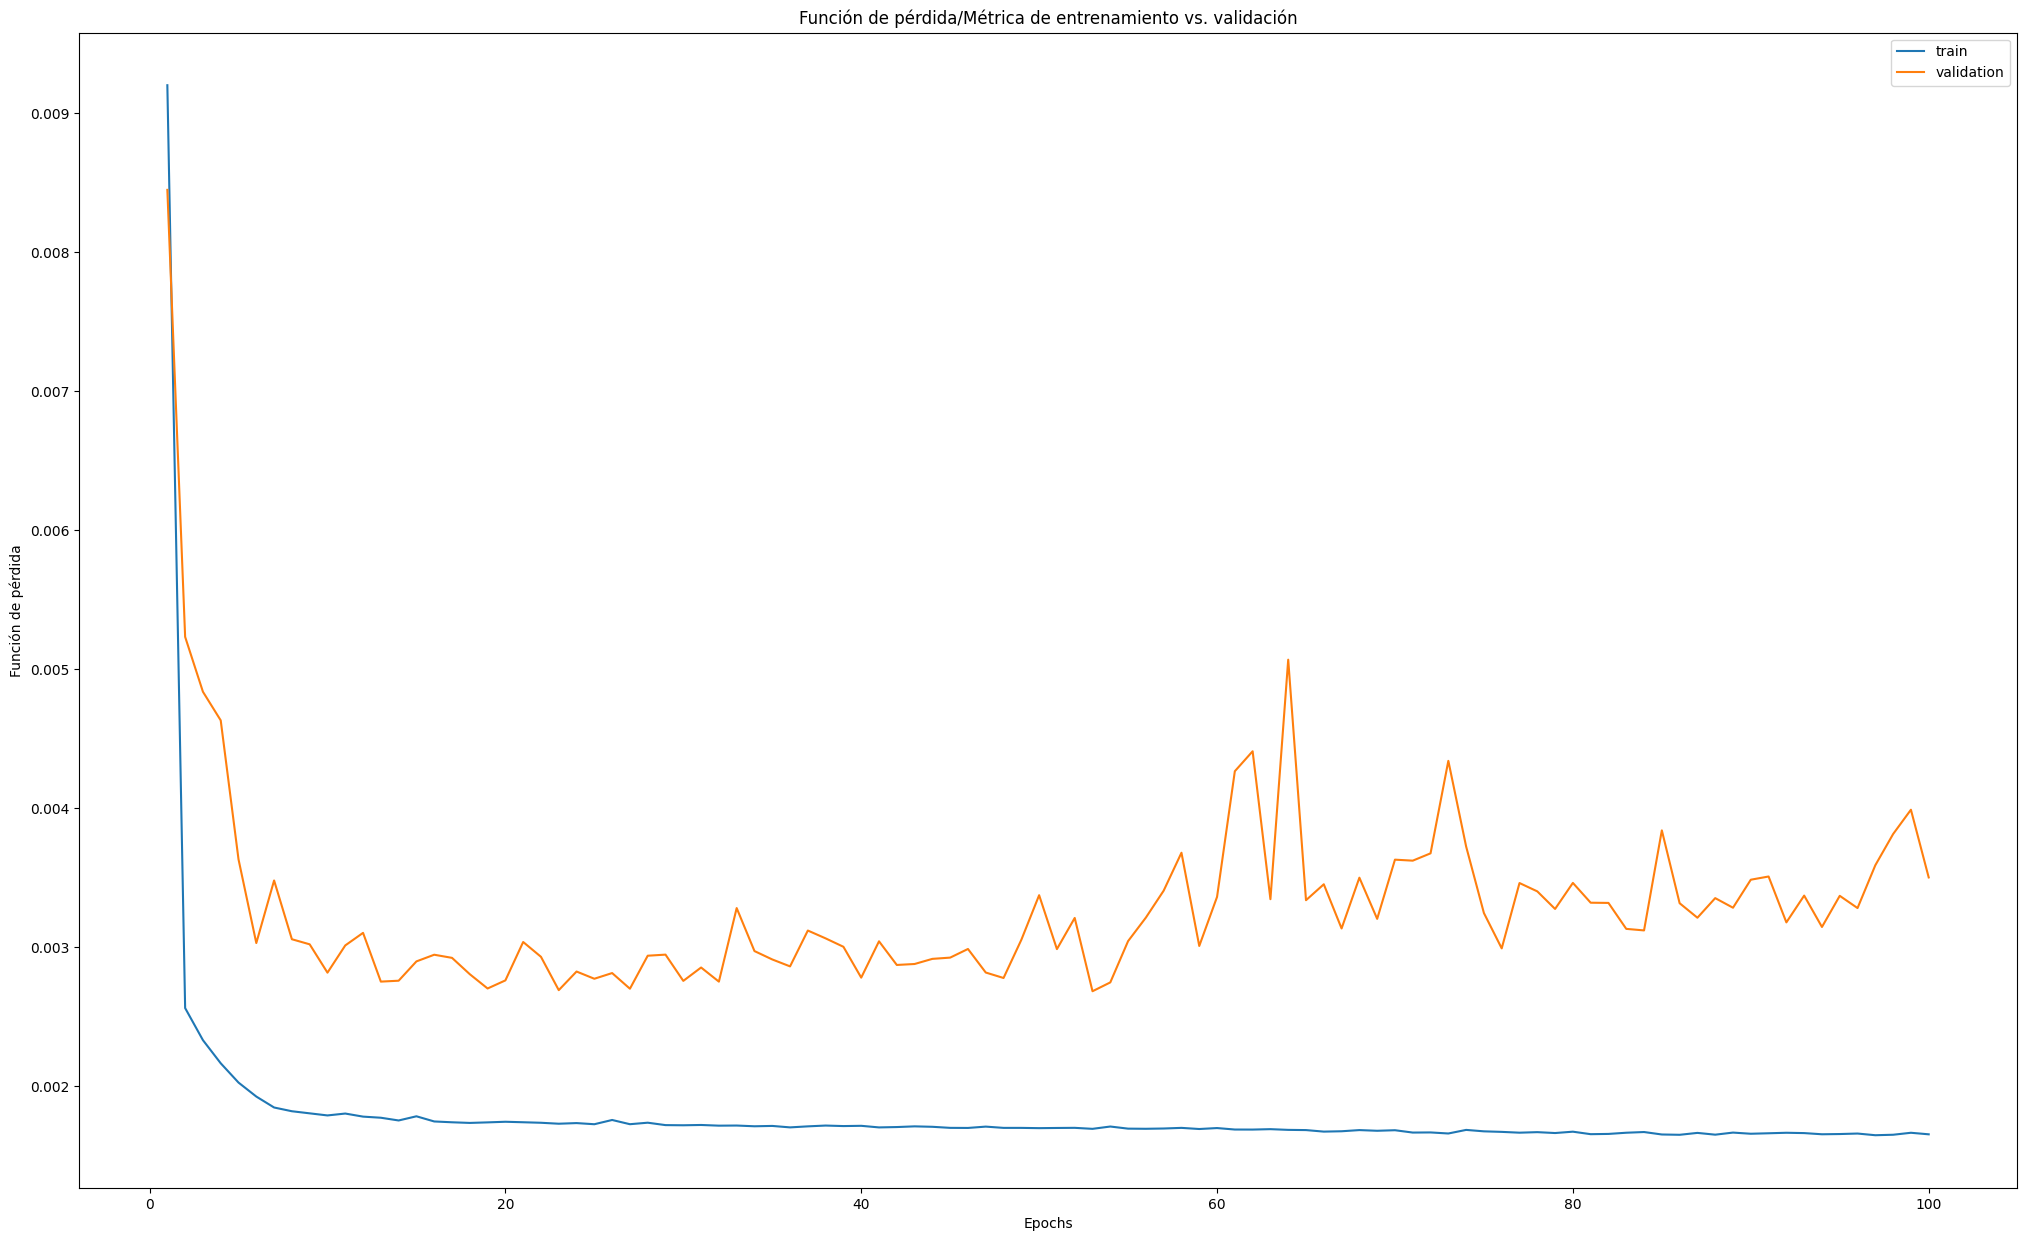

In [ ]:
epoch_count_2 = range(1, len(hist_2.history['loss']) + 1)
plt.plot(epoch_count_2,hist_2.history['loss'],label='train')
plt.plot(epoch_count_2,hist_2.history['val_loss'],label='validation')
plt.title("Estimación de tendencia: caso cíclico 168 hs.")
plt.legend()
plt.title ("Función de pérdida/Métrica de entrenamiento vs. validación")
plt.xlabel("Epochs")
plt.ylabel("Función de pérdida")
plt.show()

##### Test

In [ ]:
mse_evaluate_2=model_2.evaluate(X_test, y_test)
print (mse_evaluate_2)

23/23 [==============================] - 0s 6ms/step - loss: 0.0080
0.008037236519157887


In [ ]:
# Predecir train.
y_hat_train_2=model_2.predict(X_train)
print (y_hat_train_2.shape)
# Predecir test.
y_hat_2= model_2.predict(X_test)
print (y_hat_2.shape)

429/429 [==============================] - 3s 6ms/step
(13702, 1)
23/23 [==============================] - 0s 9ms/step
(722, 1)


In [1]:
testScore_2 = np.sqrt(mean_squared_error(y_test, y_hat_2.flatten()))
print('Resultado del test: %.2f RMSE' % (testScore_2))

Resultado del test: 0.09 RMSE


In [ ]:
# Invertir predicciones de test.
print (y_hat_2.shape)
y_hat_2 = scaler.inverse_transform(y_hat_2)
print (y_hat_2.shape)
print (y_test.shape)

y_test_inv_2 = y_test.reshape(-1,1)
y_test_inv_2 = scaler.inverse_transform(y_test_inv_2)

y_test_inv_2 = y_test_inv_2.flatten()
print (y_test_inv_2.shape)

(722, 1)
(722, 1)
(722,)
(722,)


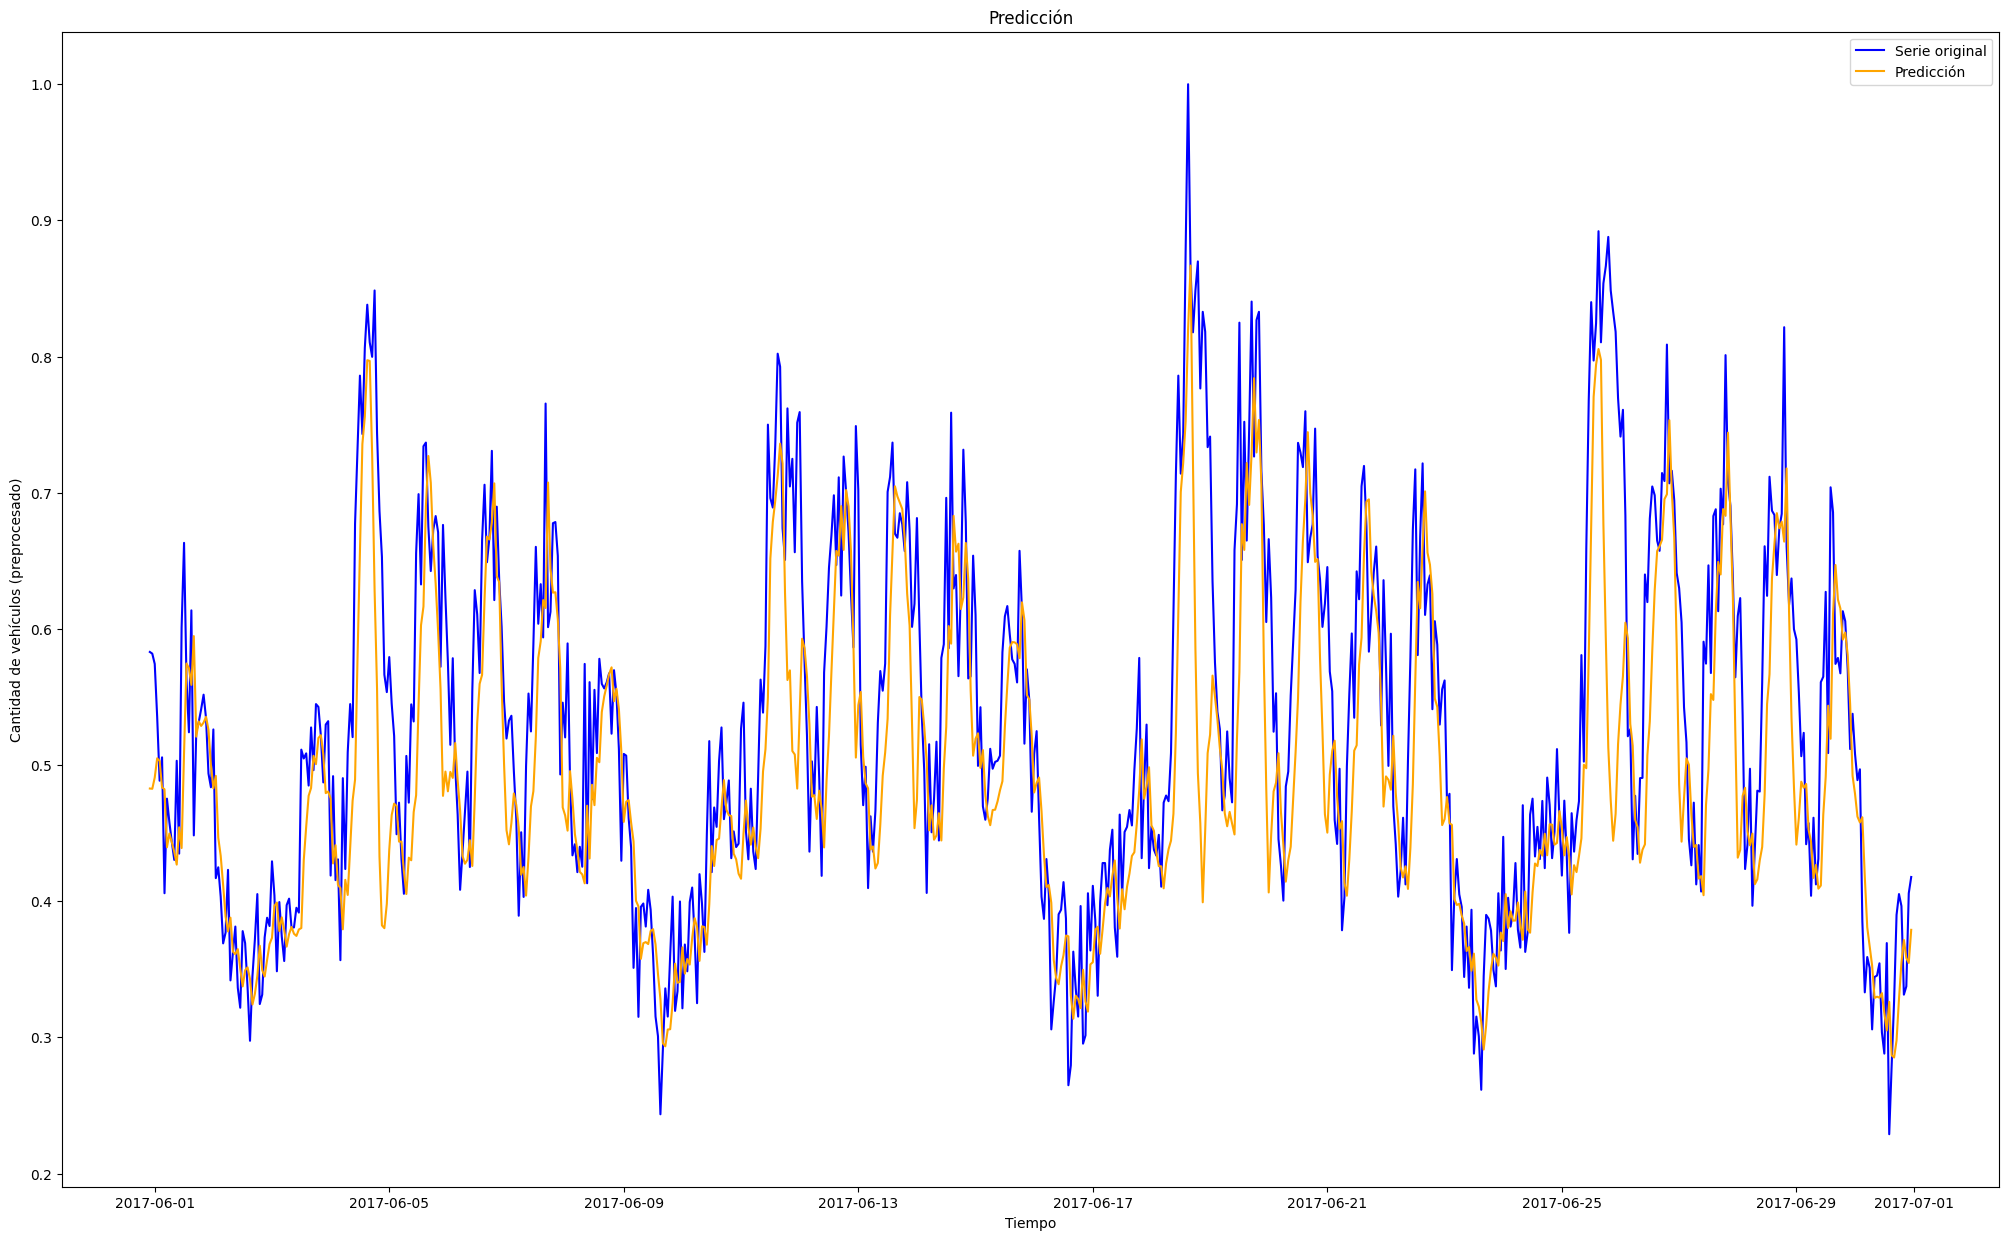

In [ ]:
# Gráfica
init_2=len(resid)-len(y_test_inv_2)+start
plt.plot(dfj2.index[init_2:],y_test_inv_2, color="blue",label="Serie original")
plt.plot(dfj2.index[init_2:],y_hat_2, color="orange",label="Predicción")
plt.legend()
plt.title("Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos (preprocesado)")
plt.show()

In [ ]:
# Invertir predicciones de train.
print(y_hat_train_2.shape)
y_hat_train_2 = scaler.inverse_transform(y_hat_train_2)
print (y_hat_train_2.shape)

(13702, 1)
(13702, 1)


In [ ]:
# Mover las predicciones de train para graficar.
y_hat_train_Plot_2 = np.empty_like(resid.reshape(-1,1))
y_hat_train_Plot_2[:,:] = np.nan
y_hat_train_Plot_2[look_back:len(y_hat_train_2)+look_back, :] = y_hat_train_2
print (y_hat_train_Plot_2.shape)

(14448, 1)


In [ ]:
# Mover las predicciones de test
y_hat_Plot_2 = np.empty_like(resid.reshape(-1,1))
y_hat_Plot_2[:, :] = np.nan
y_hat_Plot_2[len(y_hat_train_2)+(look_back):len(resid.reshape(-1,1)), :] = y_hat_2
print (y_hat_Plot_2.shape)

(14448, 1)


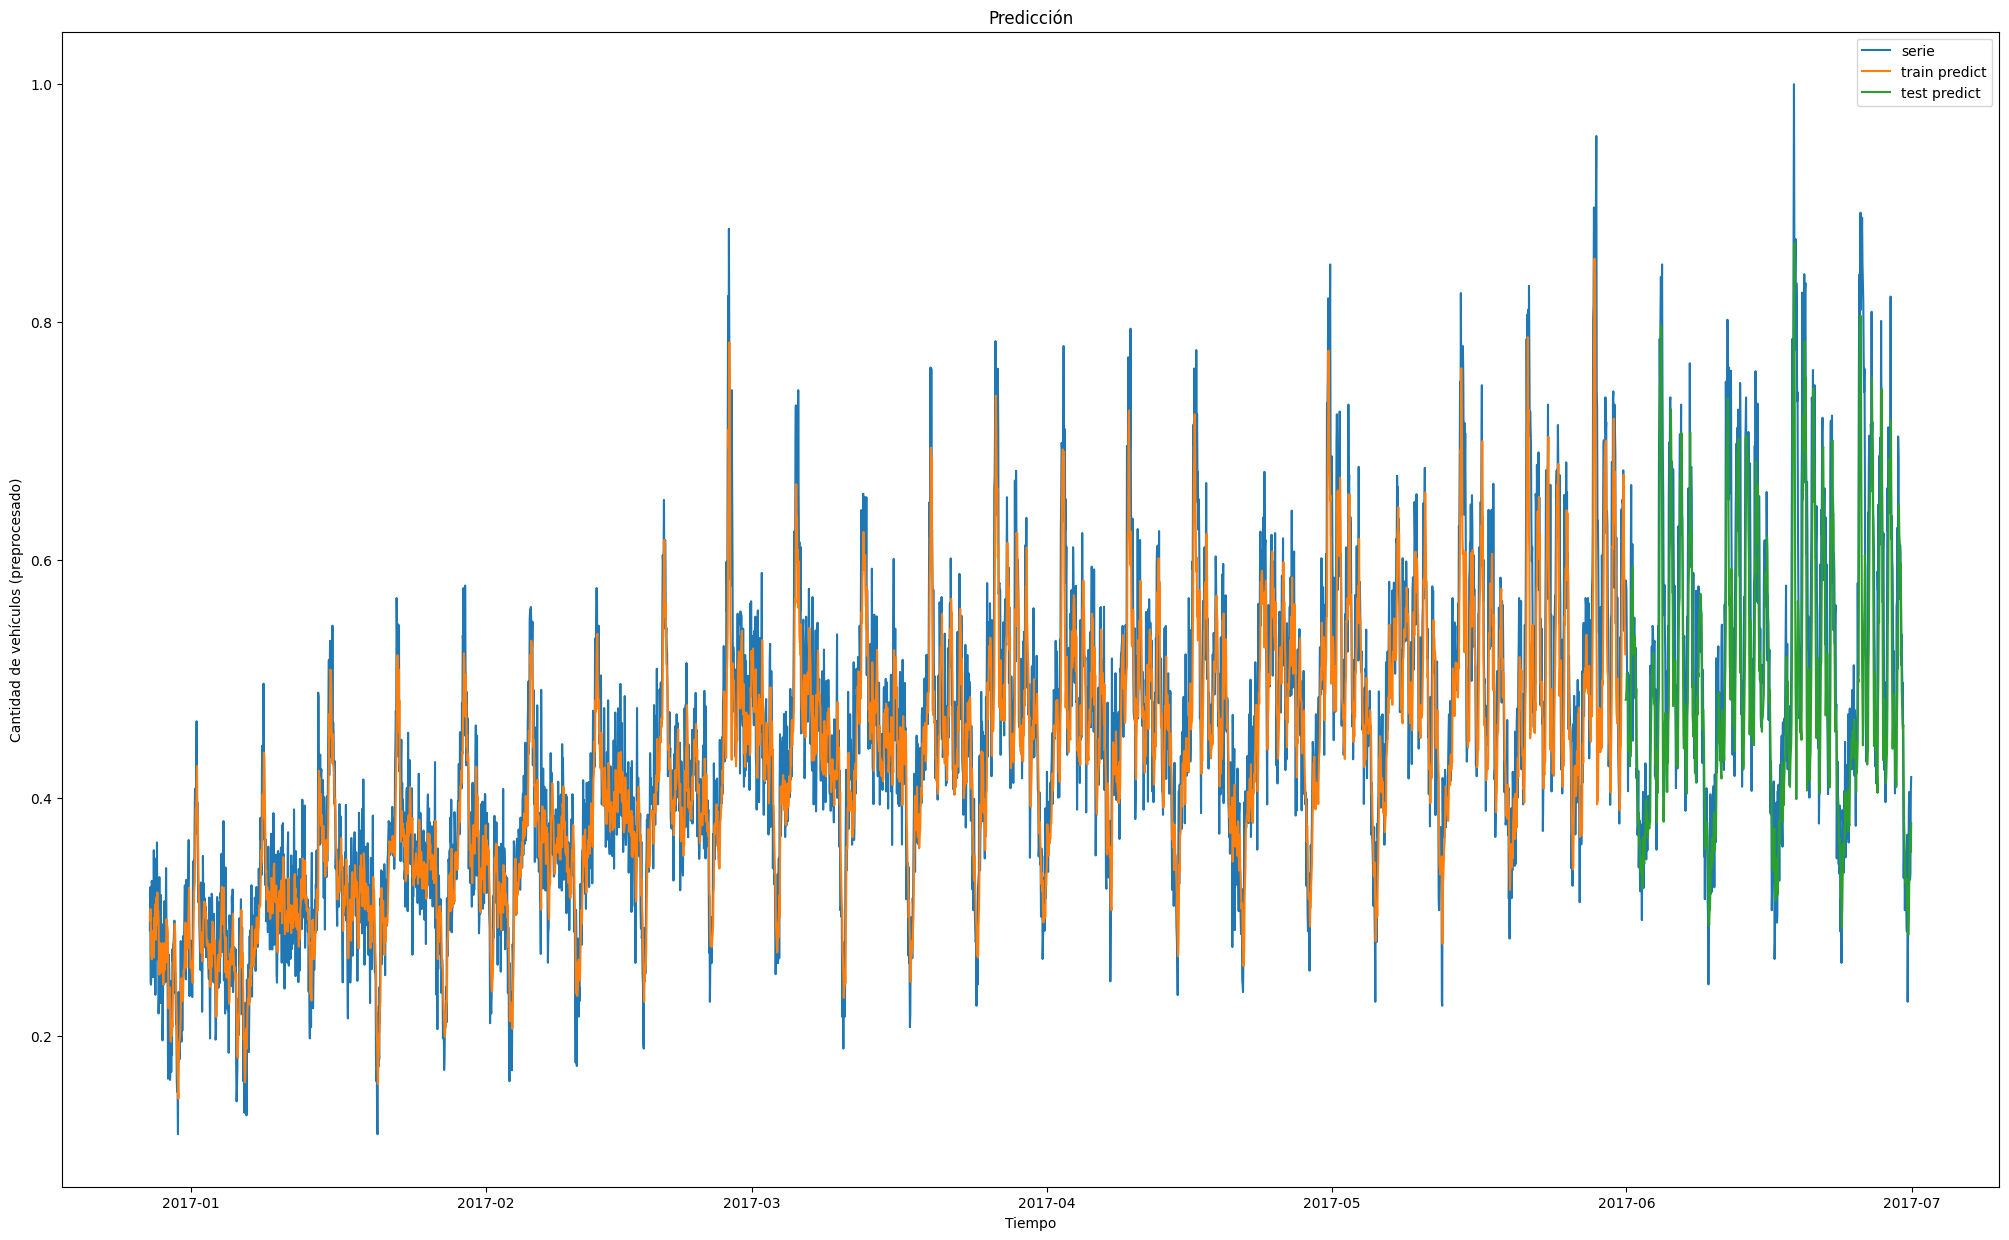

In [ ]:
zoom=10000
plt.plot(dfj2.index[start+zoom:],scaler.inverse_transform(resid.reshape(-1,1))[zoom:],label='serie')
plt.plot(dfj2.index[start+zoom:],y_hat_train_Plot_2[zoom:],label='train predict')
plt.plot(dfj2.index[start+zoom:],y_hat_Plot_2[zoom:],label='test predict')
plt.legend()
plt.title("Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos (preprocesado)")
plt.show()

##### Inferencia

In [3]:
cant_predictions_NN_2=len(resid)-look_back

predict_one_2=resid[cant_predictions_NN_2:].reshape(1, look_back, 1)

y_hat_one_2 = model_2.predict(predict_one_2)
y_hat_one_2 = scaler.inverse_transform(y_hat_one_2)
print ("El valor predicho es:",y_hat_one_2)
print (y_hat_one_2.shape)

1/1 [==============================] - 0s 44ms/step
El valor predicho es: [[0.39497685]]
1,  1


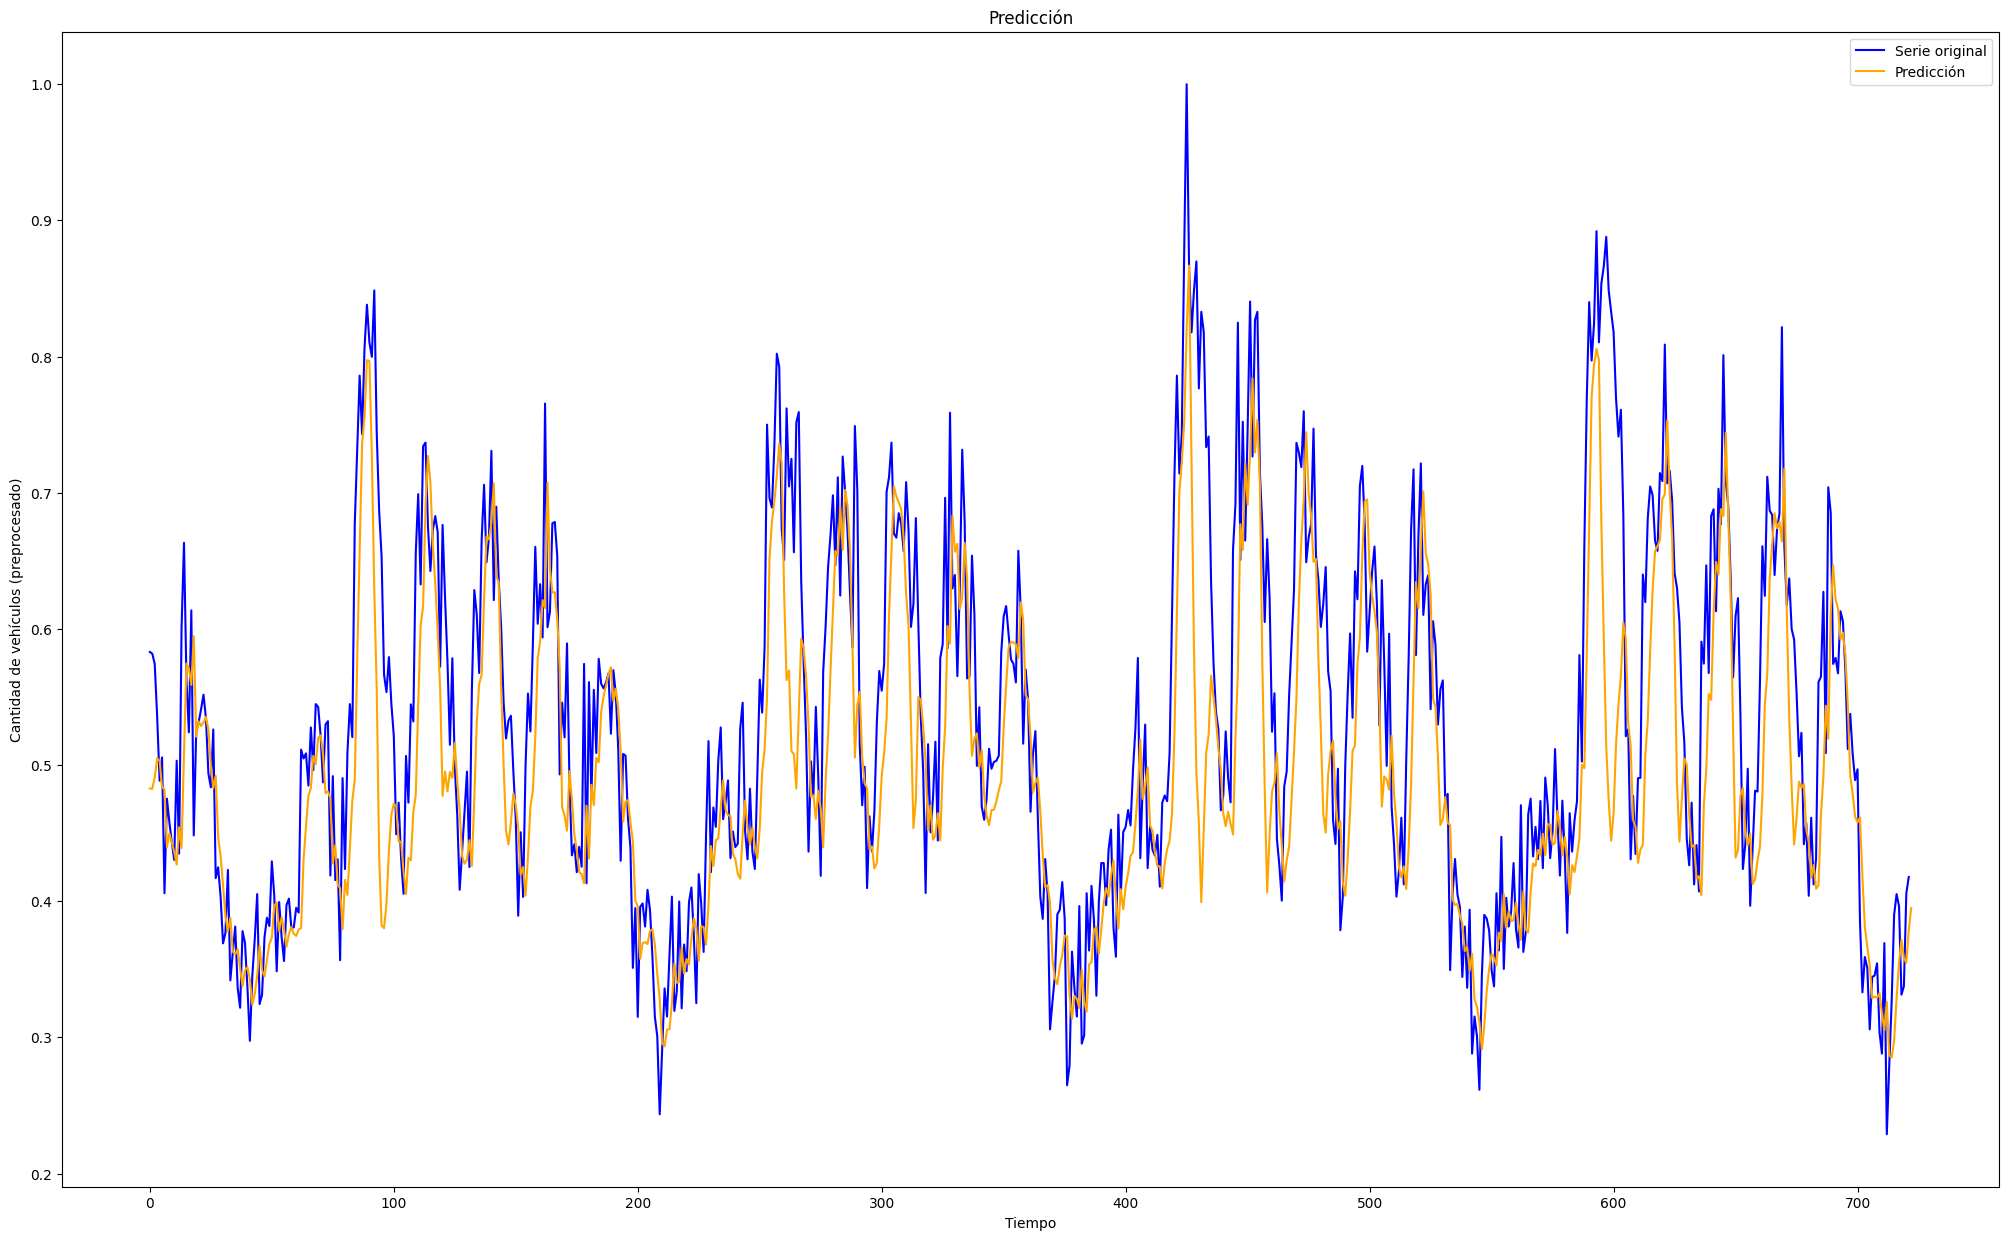

In [ ]:
y_hat_complete_2=np.concatenate((y_hat_2,y_hat_one_2))

plt.plot(y_test_inv_2, color="blue",label="Serie original")
plt.plot(y_hat_complete_2, color="orange",label="Predicción")
plt.legend()
plt.title("Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos (preprocesado)")
plt.show()

## Conclusiones

Observamos que SARIMA da prioridad solo a la tendencia cíclica diaria (24 horas), en cambio las redes neuronales siguen también la tendencia semanal.